In [1]:
import matplotlib.pyplot as plt
import jax
jax.config.update('jax_default_device',jax.devices()[-1])
import jax.numpy as jnp
import optax
import jax
import numpy as np
# import ot
# import ot.plot
import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn, solve
import matplotlib.pylab as pl
from stochastic_interpolant.neural_network import NeuralNetwork
from stochastic_interpolant.dataloaders import (
    DatasetSampler,GaussianReferenceSampler,
    IndependenceCouplingSampler,build_trainloader,testloader_factory,OTCouplingSampler)
from stochastic_interpolant.loss_functions import get_linear_interpolants,root_prod_gamma,root_prod_gammadot,get_loss_functions
from stochastic_interpolant.data_generators import inf_train_gen
# from stochastic_interpolant.model_training import train_model

In [2]:
# Target sample
num_target = 5000
target_samples = inf_train_gen('2spirals',rng = 50,batch_size = num_target)

# Reference Sample
reference_samples = jax.random.normal(jax.random.PRNGKey(13334),(num_target,2))

ref_sampler = DatasetSampler(reference_samples)
target_sampler = DatasetSampler(target_samples)

ot_sampler = OTCouplingSampler(ref_sampler,target_sampler)

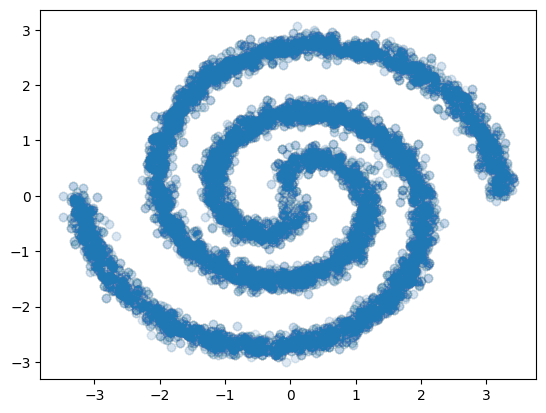

: 

In [3]:
pkey = jax.random.PRNGKey
target_batches = []

for i in range(100):
    ref,target = ot_sampler.sample_batch(1000,pkey(i))
    target_batches +=[target]

targets = jnp.vstack(target_batches)
plt.scatter(targets[:,0],targets[:,1],alpha = 0.01)

In [7]:
# Define a linear problem with that cost structure.
ot_prob = linear_problem.LinearProblem(geom)
# Create a Sinkhorn solver
# solver = sinkhorn.Sinkhorn()
# Solve OT problem
# ot = solver(ot_prob)
solve_fn = jax.jit(solve)
ot = solve_fn(geom)
# The out object contains many things, among which the regularized OT cost
print(
    " Sinkhorn has converged: ",
    ot.converged,
    "\n",
    "Error upon last iteration: ",
    ot.errors[(ot.errors > -1)][-1],
    "\n",
    "Sinkhorn required ",
    jnp.sum(ot.errors > -1),
    " iterations to converge. \n",
    "Entropy regularized OT cost: ",
    ot.reg_ot_cost,
    "\n",
    "OT cost (without entropy): ",
    jnp.sum(ot.matrix * ot.geom.cost_matrix),
)

 Sinkhorn has converged:  True 
 Error upon last iteration:  0.00068796054 
 Sinkhorn required  6  iterations to converge. 
 Entropy regularized OT cost:  1.4432423 
 OT cost (without entropy):  1.2848551


In [8]:
# Target sample
num_target = 5000
target_samples = inf_train_gen('2spirals',rng = 50,batch_size = num_target)

# Reference Sample
reference_samples = jax.random.normal(jax.random.PRNGKey(13334),(num_target,2))

In [10]:
mini_batch_size = 10
data_key = jax.random.PRNGKey(42)
target_key, reference_key = jax.random.split(data_key,2)
target_batch = jax.random.choice(target_key,target_samples,(mini_batch_size,))
reference_batch = jax.random.choice(reference_key,reference_samples,(mini_batch_size,))
a, b = jnp.ones((mini_batch_size,)), jnp.ones((mini_batch_size,))

In [11]:
geom = ott.geometry.pointcloud.PointCloud(reference_batch, target_batch)
prob = ott.problems.linear.linear_problem.LinearProblem(geom)

In [12]:
solver = ott.solvers.linear.sinkhorn.Sinkhorn()
solve_fn = jax.jit(solver)
ot = solve_fn(prob)

In [14]:
ot.geom.cost_matrix

Array([[ 9.4307    ,  6.0649786 , 14.0318165 ,  5.759452  , 23.063438  ,
        12.644661  ,  9.453028  ,  6.2646976 ,  2.1707525 , 21.40744   ],
       [ 9.164077  ,  2.1772242 , 11.101356  ,  2.8828735 , 29.782606  ,
        16.189072  ,  1.8791761 ,  2.6235857 ,  5.0305133 , 29.54181   ],
       [ 0.8130243 ,  3.8256001 ,  3.0966606 ,  2.5309913 ,  7.11199   ,
         1.5847256 , 11.350457  ,  3.3316758 ,  0.815648  ,  7.038604  ],
       [11.666937  ,  3.3289967 , 13.697433  ,  4.2890935 , 34.12098   ,
        19.45155   ,  2.0210028 ,  3.9075837 ,  6.7194376 , 33.776157  ],
       [ 1.9015948 ,  1.6476233 ,  4.1402836 ,  0.9987402 , 12.830017  ,
         4.674532  ,  6.639867  ,  1.4633875 ,  0.4288003 , 12.6622925 ],
       [ 0.09250736,  4.0267224 ,  1.2740736 ,  2.6758823 ,  5.8758583 ,
         0.978724  , 11.891477  ,  3.4041996 ,  2.542165  ,  6.4772043 ],
       [ 0.652575  ,  6.7549295 ,  1.4901495 ,  5.0177336 ,  3.6282787 ,
         0.438241  , 16.17504   ,  5.91303   

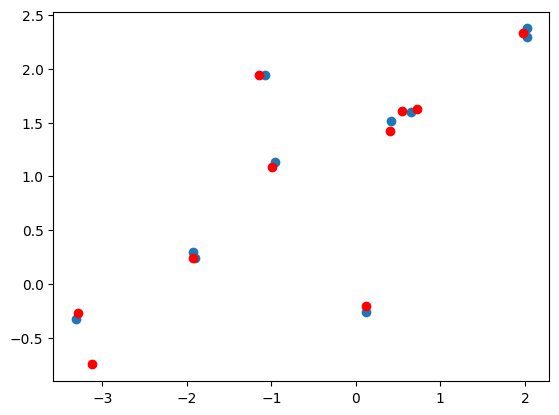

In [19]:
def sample_from_row(key,probs):
    return jax.random.choice(key,jnp.arange(len(probs)),p = probs)

mat_sample = jax.jit(jax.vmap(sample_from_row,in_axes=(0,0)))

keys = jax.random.split(jax.random.PRNGKey(3),len(ot.matrix))
pmat = ot.matrix/jnp.sum(ot.matrix,axis=1,keepdims = True)

inds = mat_sample(keys,pmat)

ot_batch = target_batch[inds] + 0.05 * jax.random.normal(jax.random.PRNGKey(13824),(target_batch.shape))

plt.scatter(ot_batch[:,0],ot_batch[:,1])
plt.scatter(target_batch[:,0],target_batch[:,1],c = 'red')

In [22]:
from stochastic_interpolant.dataloaders import OTCouplingSampler,DatasetSampler

In [26]:
# Target sample
num_target = 5000
target_samples = inf_train_gen('2spirals',rng = 50,batch_size = num_target)

# Reference Sample
reference_samples = jax.random.normal(jax.random.PRNGKey(13334),(num_target,2))

ref_sampler = DatasetSampler(reference_samples)
target_sampler = DatasetSampler(target_samples)

ot_sampler = OTCouplingSampler(ref_sampler,target_sampler)

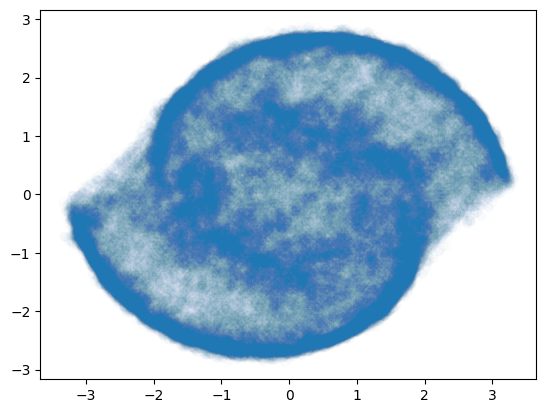

In [38]:
pkey = jax.random.PRNGKey
target_batches = []

for i in range(100):
    ref,target = ot_sampler.sample_batch(1000,pkey(i))
    target_batches +=[target]

targets = jnp.vstack(target_batches)
plt.scatter(targets[:,0],targets[:,1],alpha = 0.01)

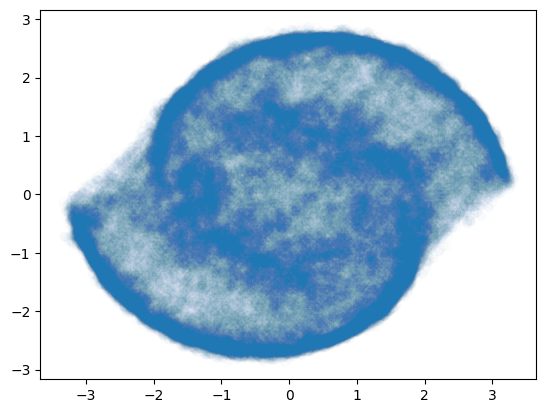

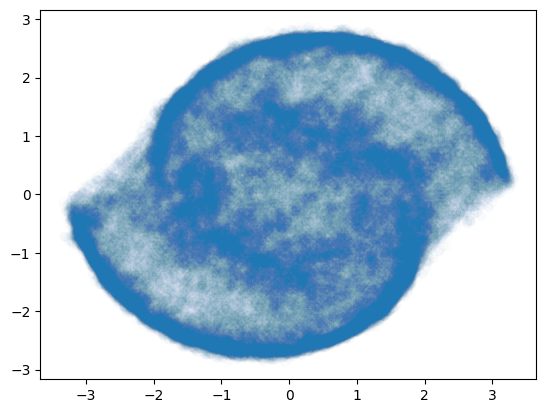

In [239]:
M = ot.dist(reference_batch,target_batch,p=1)

In [240]:
a, b = jnp.ones((mini_batch_size,)), jnp.ones((mini_batch_size,))
G0 = ot.emd(a,b,M)

Text(0.5, 1.0, 'OT matrix with samples')

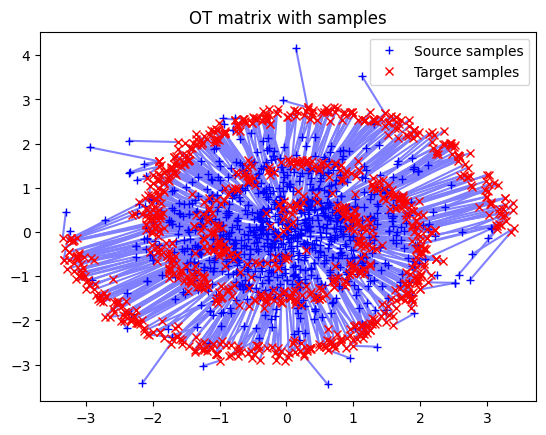

In [241]:
ot.plot.plot2D_samples_mat(np.array(reference_batch), np.array(target_batch), np.array(G0), c=[.5, .5, 1])
pl.plot(reference_batch[:, 0], reference_batch[:, 1], '+b', label='Source samples')
pl.plot(target_batch[:, 0], target_batch[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix with samples')

In [242]:
G0@target_batch

Array([[ 3.0132987 ,  0.92995304],
       [ 1.6200284 ,  0.54562664],
       [ 1.1225936 , -0.21110708],
       ...,
       [ 1.4881628 ,  0.73047024],
       [ 0.68160105, -2.5765634 ],
       [ 1.242928  , -2.0505073 ]], dtype=float32)

In [243]:
target_batch

Array([[-0.54242134,  1.5650295 ],
       [ 0.1262104 , -1.3441808 ],
       [ 0.30783322, -2.6868804 ],
       ...,
       [ 1.2974044 ,  0.98629117],
       [-3.1247025 , -0.55394506],
       [-1.6891179 , -0.9456756 ]], dtype=float32)

In [234]:
reference_batch

Array([[ 0.98999083,  0.02760527],
       [-1.7325537 ,  1.5832953 ],
       [-0.5738122 , -0.04246929],
       [ 1.8910633 , -0.46209434],
       [ 2.172503  ,  0.41984123],
       [-0.79204035,  0.91780037],
       [-0.47588974,  1.156665  ],
       [-0.06519935, -0.1658791 ],
       [-1.3465117 , -2.3524277 ],
       [ 0.68188506, -0.57585275]], dtype=float32)